# <b> Prediksi Harga Bitcoin menggunakan LSTM
### - Created by: Aziz Fatih Fauzi

## Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



## Data Preparation

In [3]:
df = pd.read_csv('dataset/BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [4]:
# membalik df agar data terurut dari tanggal terlama ke terbaru
df = df.iloc[::-1]
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2650,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53


In [5]:
df.columns

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USD'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 2650 to 0
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


In [7]:
df.isnull().sum()

unix          0
date          0
symbol        0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

In [8]:
# nilai unik di symbol
df['symbol'].unique()

array(['BTC/USD'], dtype=object)

In [9]:
# hapus kolom symbol, karena hanya ada 1 nilai
# hapus kolom unix, karena tidak digunakan
df = df.drop(columns=['symbol', 'unix'])
df.head()

,date,open,high,low,close,Volume BTC,Volume USD
2650,2014-11-28 00:00:00,363.59,381.34,360.57,376.28,3220878.18,8617.15
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,2746157.05,7245.19
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,1145566.61,3046.33
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,2520662.37,6660.56
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,2593576.46,6832.53


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2651.0,1.169319e+04,1.627255e+04,162.00,654.680000,6.408950e+03,1.070862e+04,6.754749e+04
high,2651.0,1.203856e+04,1.673924e+04,212.84,664.460000,6.540000e+03,1.095624e+04,6.900000e+04
low,2651.0,1.129654e+04,1.571830e+04,152.40,640.050000,6.312000e+03,1.030376e+04,6.625000e+04
close,2651.0,1.170933e+04,1.628291e+04,162.00,654.370000,6.407770e+03,1.072642e+04,6.755900e+04
Volume BTC,2651.0,1.330041e+07,4.715366e+07,0.00,5357.882628,1.503310e+04,3.435336e+06,7.723295e+08
Volume USD,2651.0,6.099369e+07,1.072838e+08,0.00,9516.170000,2.288982e+07,8.018383e+07,1.446125e+09


In [11]:
# ubah date menjadi datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 2650 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2651 non-null   datetime64[ns]
 1   open        2651 non-null   float64       
 2   high        2651 non-null   float64       
 3   low         2651 non-null   float64       
 4   close       2651 non-null   float64       
 5   Volume BTC  2651 non-null   float64       
 6   Volume USD  2651 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 145.1 KB


## Visualisasi Data

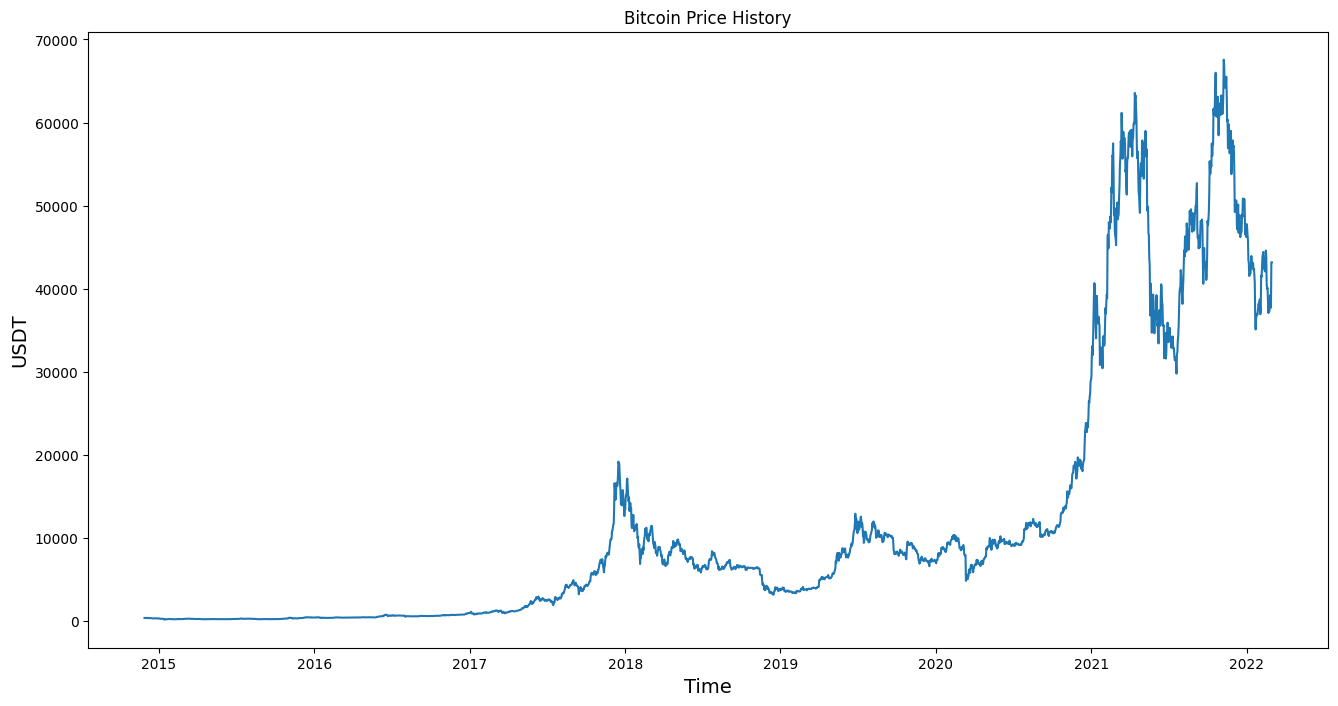

In [12]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History")
plt.plot(df["date"], df["close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

In [13]:
# cut data dari 2017 ke atas
df = df[df['date'] >= '2017-01-01']
df.head()

,date,open,high,low,close,Volume BTC,Volume USD
1885,2017-01-01,966.34,1005.00,960.53,998.80,6579903.85,6665.42
1884,2017-01-02,997.75,1032.00,990.01,1014.10,8190254.59,8085.06
1883,2017-01-03,1011.44,1039.00,999.99,1036.99,8955192.92,8779.72
1882,2017-01-04,1035.51,1139.89,1028.56,1122.56,23257162.08,21371.60
1881,2017-01-05,1114.38,1136.72,885.41,994.02,35036904.22,34736.36


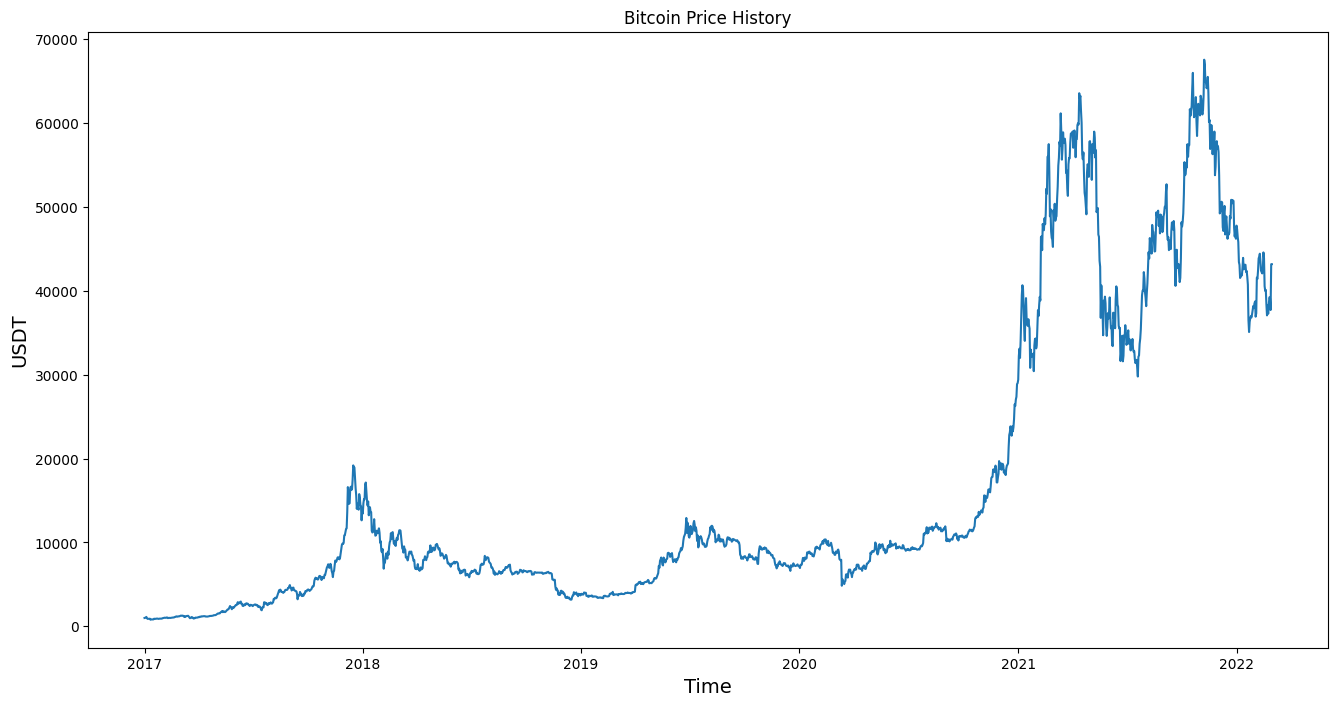

In [14]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.title("Bitcoin Price History")
plt.plot(df["date"], df["close"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

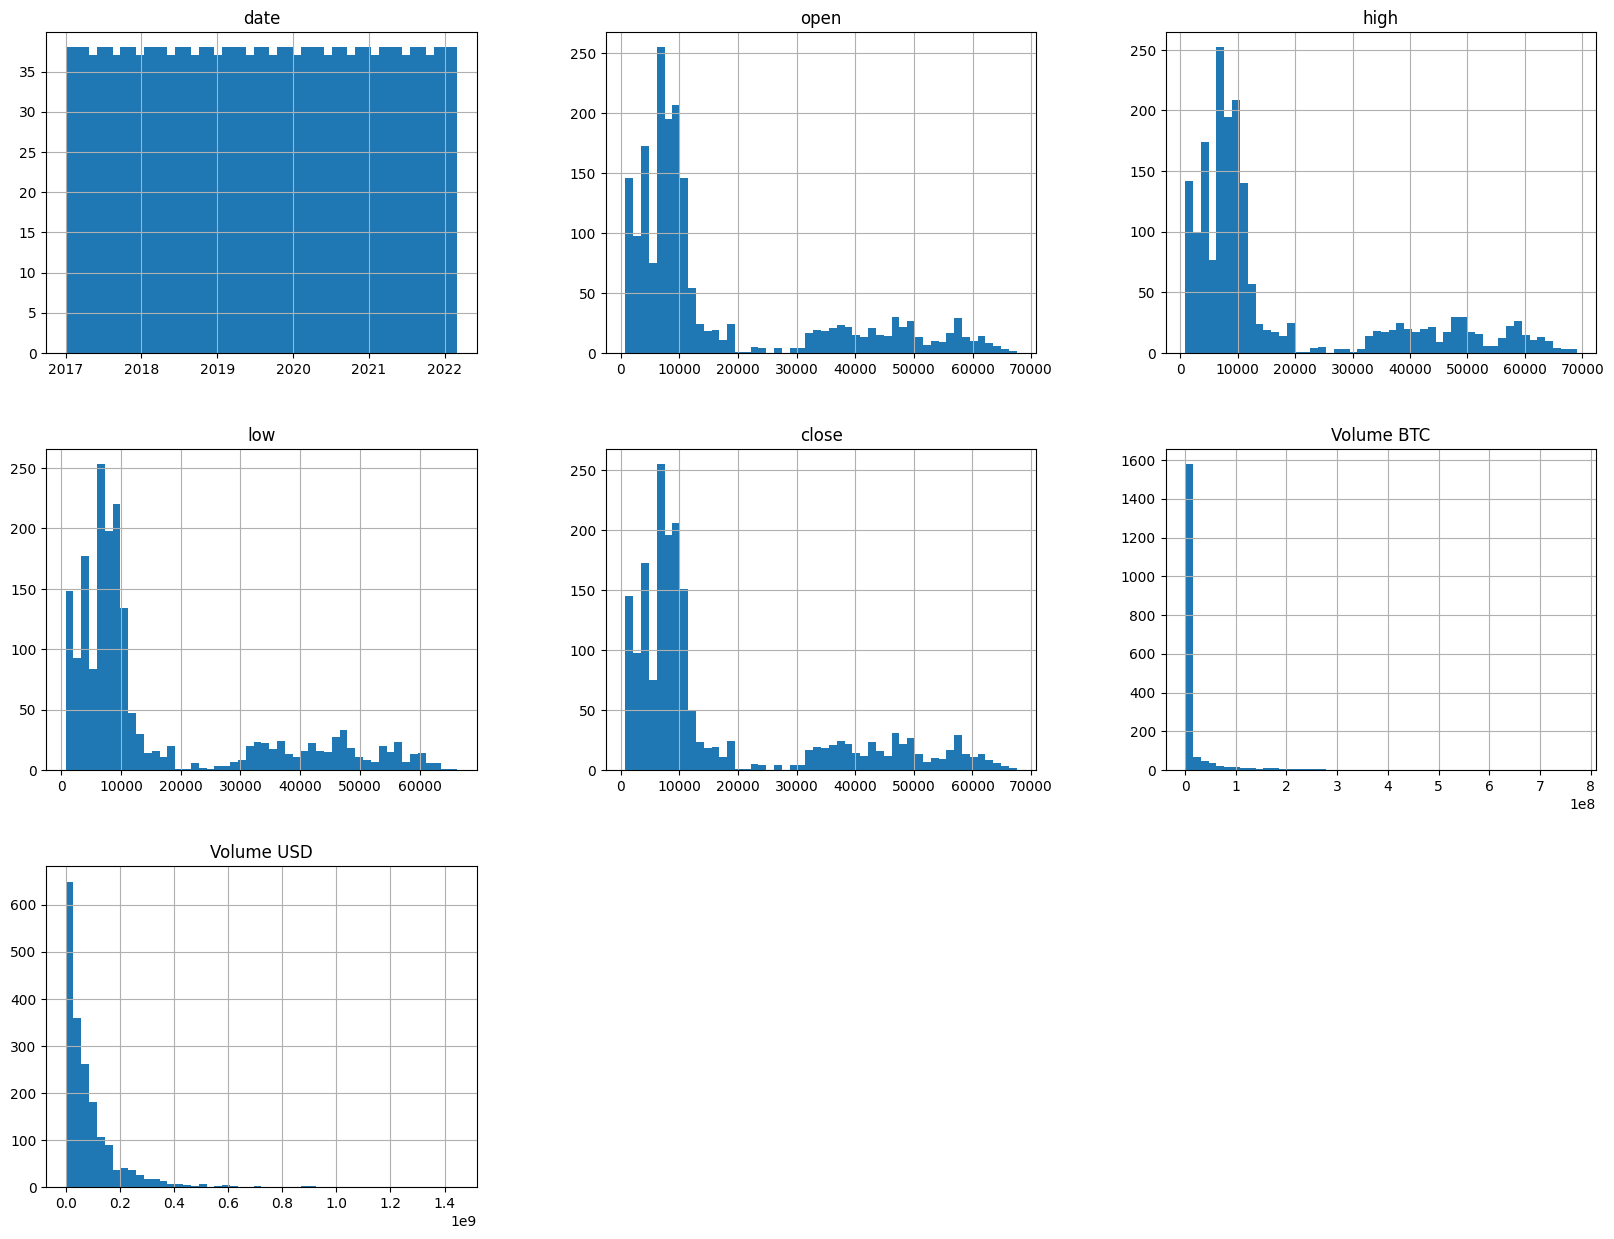

In [15]:
df.hist(bins=50, figsize=(20,15))
plt.show()

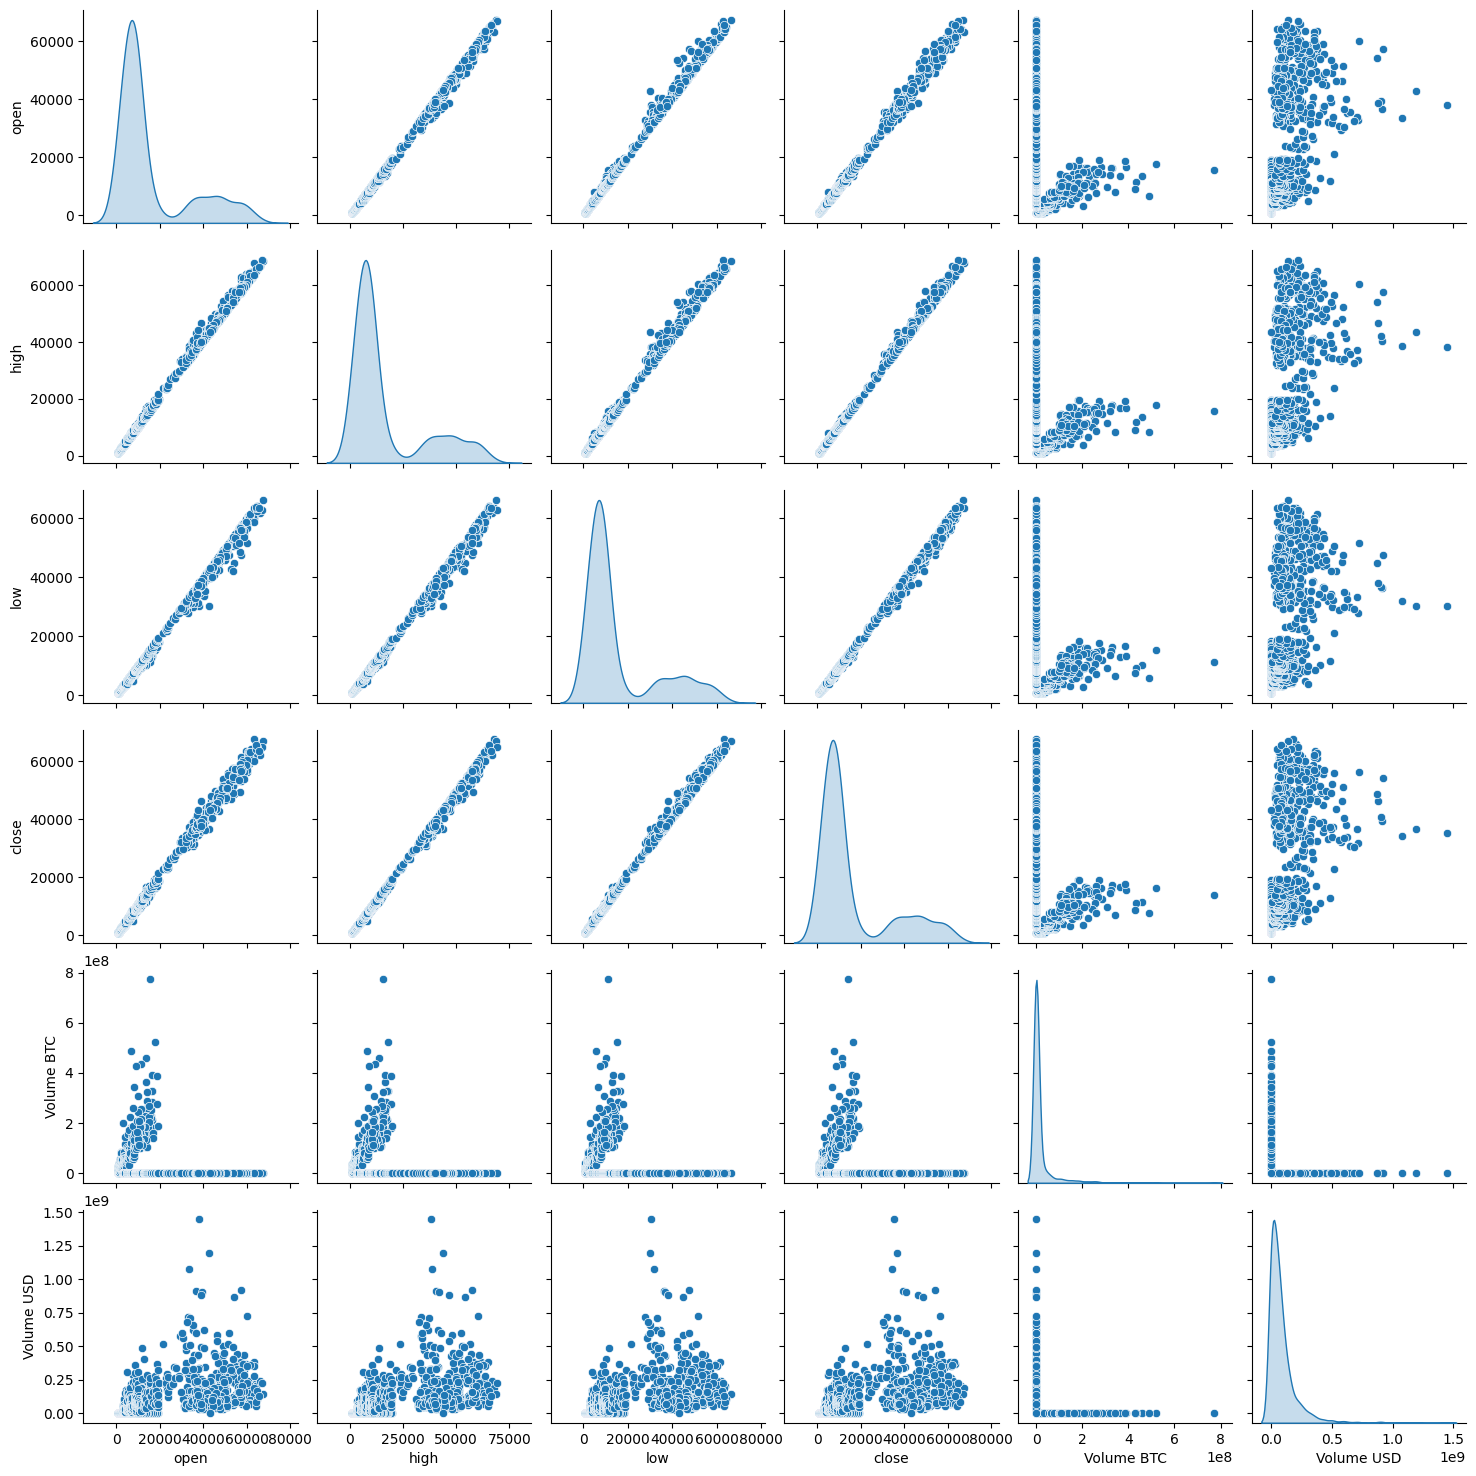

In [16]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

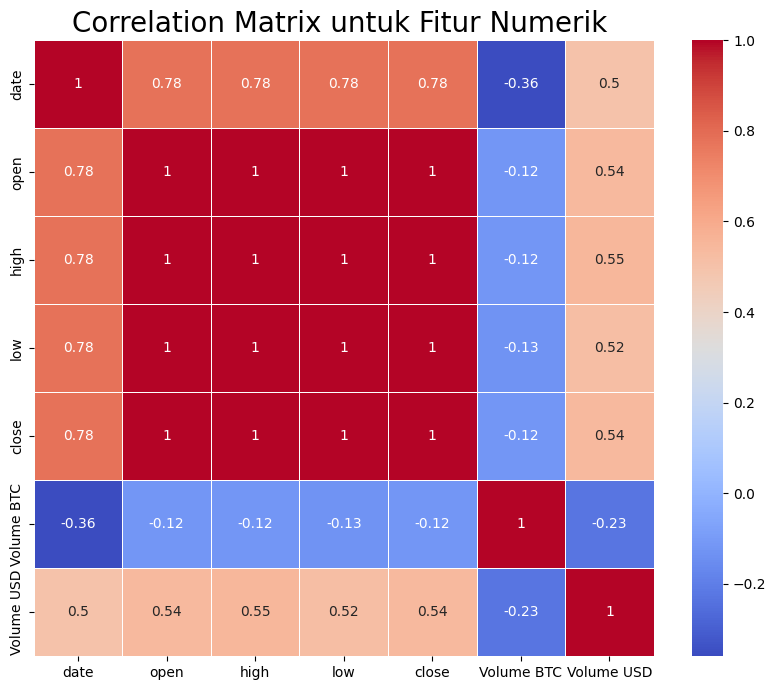

In [17]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

## Data Preprocessing

In [18]:
# Split data menjadi training dan validation set
train_data, val_data = train_test_split(df, test_size=0.2, shuffle=False)

In [19]:
# MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df[['close']])
val_data = scaler.transform(val_data[['close']])

train_data

array([[0.00314497],
       [0.00337411],
       [0.00371693],
       ...,
       [0.55299932],
       [0.6348667 ],
       [0.63496405]])

In [20]:
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [21]:
time_steps = 30

X_train, y_train = create_dataset(train_data, time_steps)
X_val, y_val = create_dataset(val_data, time_steps)

## Modeling dan Evaluasi

In [22]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30),
  tf.keras.layers.Dense(1),
])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0225 - mae: 0.1547 - val_loss: 0.0028 - val_mae: 0.0593
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.9660e-04 - mae: 0.0255 - val_loss: 0.0018 - val_mae: 0.0496
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.6822e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0493
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.8452e-04 - mae: 0.0189 - val_loss: 0.0019 - val_mae: 0.0500
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.2319e-04 - mae: 0.0193 - val_loss: 0.0018 - val_mae: 0.0492
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.3855e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0487
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.9619e-04 - mae: 0.0203 - val_loss: 0.0018 - val_mae: 0.0493
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.9144e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0494
Epoch 9/30
58/58 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


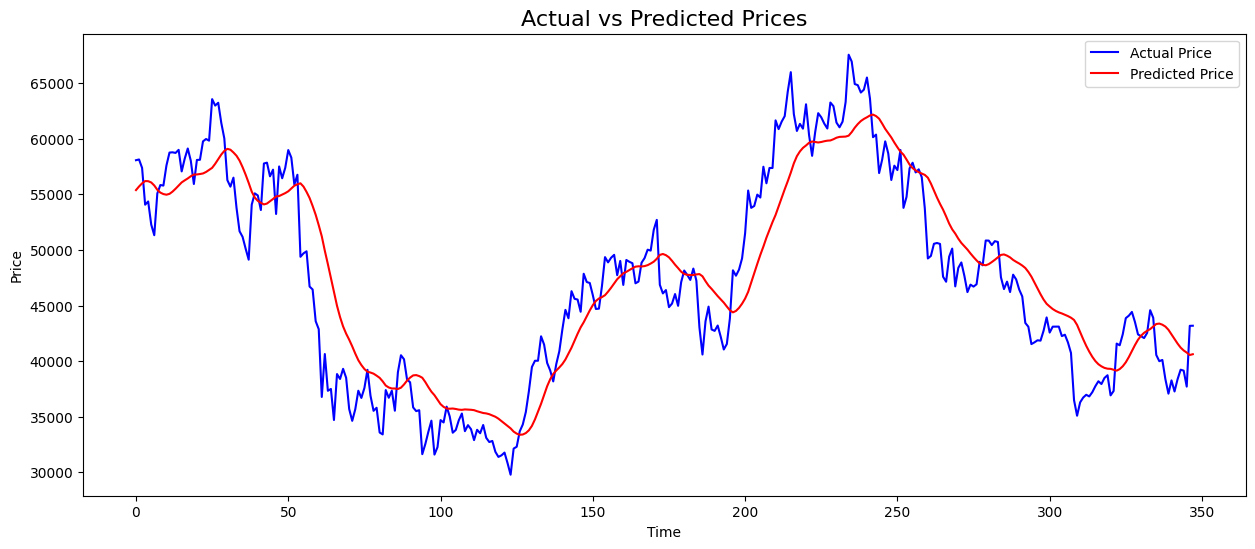

In [24]:
# Invers scaling untuk mendapatkan harga aktual dan prediksi yang sebenarnya
predictions = model.predict(X_val)
actual_prices = scaler.inverse_transform(y_val.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predictions)

# Plot harga aktual dan harga prediksi
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Perbaikan Model

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0105 - mae: 0.0861 - val_loss: 0.0020 - val_mae: 0.0499
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.8947e-04 - mae: 0.0219 - val_loss: 0.0016 - val_mae: 0.0446
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.5285e-04 - mae: 0.0193 - val_loss: 0.0015 - val_mae: 0.0434
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.9209e-04 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0427
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.3903e-04 - mae: 0.0202 - val_loss: 0.0014 - val_mae: 0.0414
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.4574e-04 - mae: 0.0149 - val_loss: 0.0013 - val_mae: 0.0405
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.9565e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 3.3261e-04 - mae: 0.0152 - val_loss: 0.0010 - val_mae: 0.0356
Epoch 9/30
58/58 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


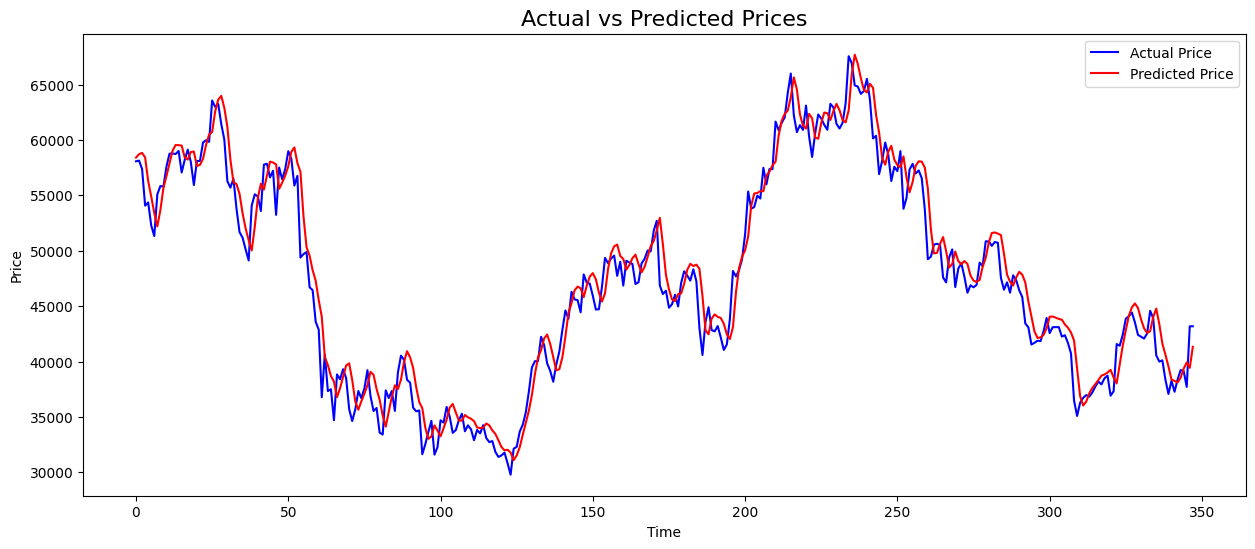

In [26]:
# Invers scaling untuk mendapatkan harga aktual dan prediksi yang sebenarnya
predictions = model.predict(X_val)
actual_prices = scaler.inverse_transform(y_val.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predictions)

# Plot harga aktual dan harga prediksi
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()